<a href="https://colab.research.google.com/github/louis-perdrix/Modal/blob/main/Copy_of_MTD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# **Question 1** 

In [ ]:
dataset = datasets.MNIST('.', download=True, train=True, transform=ToTensor())
#chargement du dataset MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
type(dataset[0][0])

torch.Tensor

In [ ]:
ds_list = [dataset[i][0] for i in range(16)]
ds_tensor = torch.stack(ds_list, dim=0) #on agrege la liste de tensor en un seul tensor de taille (16, 1, ...)

type(ds_tensor)

torch.Tensor

In [ ]:
print(ds_tensor.shape)
b = ds_tensor.view(-1, 28*28) #test du view
print(b.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 784])


In [ ]:
maxi= torch.nn.MaxPool2d(3)
avg= torch.nn.AvgPool2d(3)

In [ ]:
ds_max = maxi(ds_tensor) 
ds_avg = avg(ds_tensor)
ds_min = -maxi(-ds_tensor) 

In [ ]:
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#fonction donnee avec make_grid

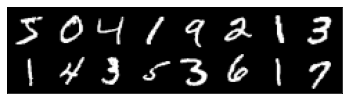

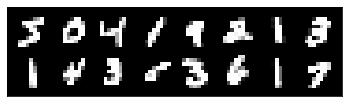

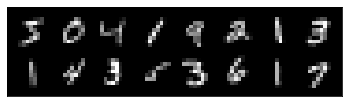

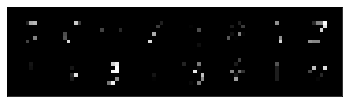

In [ ]:
show(torchvision.utils.make_grid(ds_tensor))
show(torchvision.utils.make_grid(ds_max))
show(torchvision.utils.make_grid(ds_avg))
show(torchvision.utils.make_grid(ds_min))


Certaines methodes de pooling sont moins adaptees que d'autres

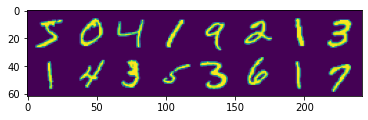

In [ ]:
plt.imshow(torchvision.utils.make_grid(ds_tensor)[0])

## **Creation d'un CNN**

In [ ]:
from torch import nn

class MyNetwork(nn.Module): 
  def __init__(self): 
      super(MyNetwork, self).__init__() #attention a bien initialiser le init
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=(2,2))
      self.layer_pool1 = torch.nn.MaxPool2d(2)    #on prend 2 pour avoir les dimensions demander en output, cad reduire de moitie la taille du dataset
      self.layer_conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=(2,2))
      self.layer_pool2 = torch.nn.MaxPool2d(2)
      self.layer_conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=(2,2))
      self.layer_lin = torch.nn.Linear(784, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = self.layer_pool1(x)
    x = self.layer_conv2(x)
    x = self.layer_pool2(x)
    x = self.layer_conv3(x)
    x = x.view(-1, 784) #le -1 permet d'avoir une dimension compatible avec la fonction linear qui prend en input des couches de 784 variables
    x = self.layer_lin(x)
    return x

In [ ]:
from torchsummary import summary
summary(MyNetwork(),(1, 28, 28)) #resume les caracteristiques du modele cree 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
         MaxPool2d-2            [-1, 4, 14, 14]               0
            Conv2d-3            [-1, 8, 14, 14]             808
         MaxPool2d-4              [-1, 8, 7, 7]               0
            Conv2d-5             [-1, 16, 7, 7]           3,216
            Linear-6                   [-1, 10]           7,850
Total params: 11,978
Trainable params: 11,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.05
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [ ]:
from tqdm.notebook import tqdm


In [ ]:
training_data = datasets.FashionMNIST(".",download=True,train=True, transform=ToTensor())
test_data = datasets.FashionMNIST(".",download=True,train=False, transform=ToTensor())
#on travaille dans la suite avec le dataset FashionMNIST

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
def trainer(dataset,model,loss_fn,epoch=5,batch_size=50,rate=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), rate)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
  for i in range(epoch):
    for x in tqdm(data_loader):
      y_pred = model(x[0])
      loss = loss_fn(y_pred,x[1])
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


def success_rate_vector(model,test_data):
  count = 0
  for test in test_data:
    with torch.no_grad():
      if abs(torch.argmax(model(test[0])) - test[1])==0:
        count += 1
  return 100*count/len(test_data)

In [ ]:
net = MyNetwork() #on appelle un objet de la classe correspondante 
trainer(training_data, net, nn.CrossEntropyLoss())

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
success_rate_vector(net, test_data)

87.46

Testons avec differents parametres 

In [ ]:
class MyNetwork5(nn.Module): 
  def __init__(self): 
      super(MyNetwork5, self).__init__() 
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, padding=(2,2))
      self.layer_pool1 = torch.nn.MaxPool2d(2)    #on prend 2 pour avoir les dimensions demander en output, cad reduire de moitie la taille du dataset
      self.layer_conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, padding=(2,2))
      self.layer_pool2 = torch.nn.MaxPool2d(2)
      self.layer_conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=(2,2))
      self.layer_lin = torch.nn.Linear(8*7*7, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = self.layer_pool1(x)
    x = self.layer_conv2(x)
    x = self.layer_pool2(x)
    x = self.layer_conv3(x)
    x = x.view(-1, 8*7*7)
    x = self.layer_lin(x)
    return x

In [ ]:
net5 = MyNetwork5()
#avec des couches moins profondes 
trainer(training_data, net5, nn.CrossEntropyLoss())

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
success_rate_vector(net5, test_data)

85.71

modele un peu moins performant car les couches sont moins profondes

In [ ]:
class MyNetwork6(nn.Module): 
  def __init__(self): 
      super(MyNetwork6, self).__init__() 
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=(1,1))
      self.layer_pool1 = torch.nn.MaxPool2d(2)    
      self.layer_conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=(1,1))
      self.layer_pool2 = torch.nn.MaxPool2d(2)
      self.layer_conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=(1,1))
      self.layer_lin = torch.nn.Linear(16*7*7, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = self.layer_pool1(x)
    x = self.layer_conv2(x)
    x = self.layer_pool2(x)
    x = self.layer_conv3(x)
    x = x.view(-1, 16*7*7)
    x = self.layer_lin(x)
    return x

In [ ]:
net6 = MyNetwork6()
#avec un kernel plus petit 
trainer(training_data, net6, nn.CrossEntropyLoss())

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
success_rate_vector(net6, test_data)

87.09

Le resultat est relativement similaire malgre le changement de kernel

## **Creation d'un reseau moins profond**

In [ ]:
class MyNetwork8(nn.Module): 
  def __init__(self): 
      super(MyNetwork8, self).__init__() 
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=(2,2))
      self.layer_lin = torch.nn.Linear(4*28*28, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = x.view(-1, 4*28*28)
    x = self.layer_lin(x)
    return x

In [ ]:
summary(MyNetwork8(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
            Linear-2                   [-1, 10]          31,370
Total params: 31,474
Trainable params: 31,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


31474 parametres pour ce modele contre 11978 pour le premier: du au fait que les full connected layers prennent des input de plus grande dimension dans MyNetwork8

In [ ]:
net8 = MyNetwork8()
#la derniere couche linear prend une entree avec beaucoup plus de donnees 
trainer(training_data, net8, nn.CrossEntropyLoss())

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
success_rate_vector(net8, test_data)

83.87

# LeNet

In [ ]:
class LeNet(nn.Module): 
  def __init__(self): 
      super(LeNet, self).__init__() 
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=(2,2))
      self.layer_pool1 = torch.nn.MaxPool2d(2)    
      self.layer_conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
      self.layer_pool2 = torch.nn.MaxPool2d(2)
      self.layer_lin1 = torch.nn.Linear(16*5*5, 120)
      self.layer_lin2 = torch.nn.Linear(120, 84)
      self.layer_lin3 = torch.nn.Linear(84, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = self.layer_pool1(x)
    x = self.layer_conv2(x)
    x = self.layer_pool2(x)
    x = x.view(-1, 16*5*5)
    x = self.layer_lin1(x)
    x = self.layer_lin2(x)
    x = self.layer_lin3(x)
    return x

In [ ]:
lenet = LeNet()

trainer(training_data, lenet, nn.CrossEntropyLoss())

In [ ]:
success_rate_vector(lenet, test_data)

# Alexnet

In [ ]:
  import torchvision.models as models
  # load pretrained model
  alexnet = models.alexnet(pretrained=True)
  # access weights from first layer
  filter = alexnet.features[0].weight.data
  # normalize to [0, 1]
  filter = (1/(2*filter.max()))*filter + 0.5

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
filter.shape

In [ ]:
filter

Les poids sont normalises et ont des poids plutot proches de 0.5

# **Retour au modele**

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
    ])

test_data1 = datasets.FashionMNIST(".",download=True,train=False,transform=transform)

In [ ]:
class MyNewNetwork(nn.Module): 
  def __init__(self): 
      super(MyNewNetwork, self).__init__() 
      self.layer_conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=(2,2))
      self.layer_pool1 = torch.nn.MaxPool2d(2)    
      self.layer_conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=(2,2))
      self.layer_pool2 = torch.nn.MaxPool2d(2)
      self.layer_conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=(2,2))
      self.layer_conv4 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=(2,2))
      self.layer_lin1 = torch.nn.Linear(32*7*7, 16*7*7)
      self.layer_relu1 = torch.nn.ReLU()
      self.layer_lin2 = torch.nn.Linear(16*7*7, 8*7*7)
      self.layer_relu2 = torch.nn.ReLU()
      self.layer_lin3 = torch.nn.Linear(8*7*7, 10)


  def forward(self,x): 
    x = self.layer_conv1(x)
    x = self.layer_pool1(x)
    x = self.layer_conv2(x)
    x = self.layer_pool2(x)
    x = self.layer_conv3(x)
    x = self.layer_conv4(x)
    x = x.view(-1, 32*7*7)
    x = self.layer_lin1(x)
    x = self.layer_relu1(x)
    x = self.layer_lin2(x)
    x = self.layer_relu2(x)
    x = self.layer_lin3(x)
    return x

In [ ]:
new_model = MyNewNetwork()
trainer(training_data, new_model, nn.CrossEntropyLoss())

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
success_rate_vector(new_model, test_data1)

88.61

In [ ]:
import cloudpickle as pickle
from google.colab import files

def torch_saver(net,file="temp"):
  with open(file,'wb') as f:
    pickle.dump(net,f)
    files.download(file)

In [ ]:
torch_saver(new_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>